# Creating the Dataframe and developing it

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

In [4]:
df = pd.read_csv("data/orders.csv", header=None)
names = {0: "order_id",
1: "activation_time_local",
2: "country_code",
3: "store_address",
4: "final_status",
5: "payment_status",
6: "products",
7: "products_total",
8: "purchase_total_price"}
df = df.rename(columns=names)

In [5]:
def compare_values(row):
    if row["products_total"] < row["purchase_total_price"]:
        return "under-authorized"
    else:
        return "authorized"
df["auth_status"] = df.apply(compare_values, axis=1)

# Question 1 - What percent of orders are under-authorized? 

In [6]:
under_authorized_count = df[df['auth_status'] == 'under-authorized'].shape[0]

# Calculate the total number of orders
total_orders = df.shape[0]

percentage_under_authorized = (under_authorized_count / total_orders) * 100

print(f"The percentage of orders that are under-authorized is: {percentage_under_authorized:.2f}%")

The percentage of orders that are under-authorized is: 57.58%


# Question 2 - What percent of orders would be correctly authorized w/ incremental authorisation

In [7]:
def compare_values_20(row):
    if (row["products_total"]*1.2) < row["purchase_total_price"]:
        return "under-authorized"
    else:
        return "authorized"
df["auth_status_20"] = df.apply(compare_values_20, axis=1)



In [8]:
authorized_20_count = df[df['auth_status_20'] == 'authorized'].shape[0]

# Calculate the total number of orders
total_orders = df.shape[0]

percentage_authorized = (authorized_20_count / total_orders) * 100

print(f"The percentage of orders that are authorized is: {percentage_authorized:.2f}%")

The percentage of orders that are authorized is: 69.03%


# Question 3 - Are there differences when split by country? 

In [9]:
#Create a Subset for all under-authorized orders:
df_filtered_under = df[df["auth_status"] == "under-authorized"]
#Group by country code
country_totals = pd.DataFrame(df_filtered_under.groupby('country_code')['products_total'].sum())

We want to see the percentaje of under-authorized orders for each country. To simplify the plot and avoid noise, we will group all countries that represent bellow 2% of under-authorized orders in a group call "Others"

In [11]:
#1. Create a new index (to modify the country_code)
country_totals = country_totals.reset_index(drop=False)
#2. Set the threshold (under 2%)
threshold = (country_totals["products_total"].sum())*0.02

#3. Defing a function to modiffy country code base on threshold
def other_country(row):
    if row['products_total'] < threshold:
        return 'Other'
    else:
        return row['country_code']
    
#4. Apply the function:
country_totals['country_code'] = country_totals.apply(other_country, axis=1)

We plot the results:

/var/folders/k4/q8g97p495cx7f63kbs0wzyc00000gn/T/ipykernel_2217/3908625863.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('YlOrBr', len(country_tot))


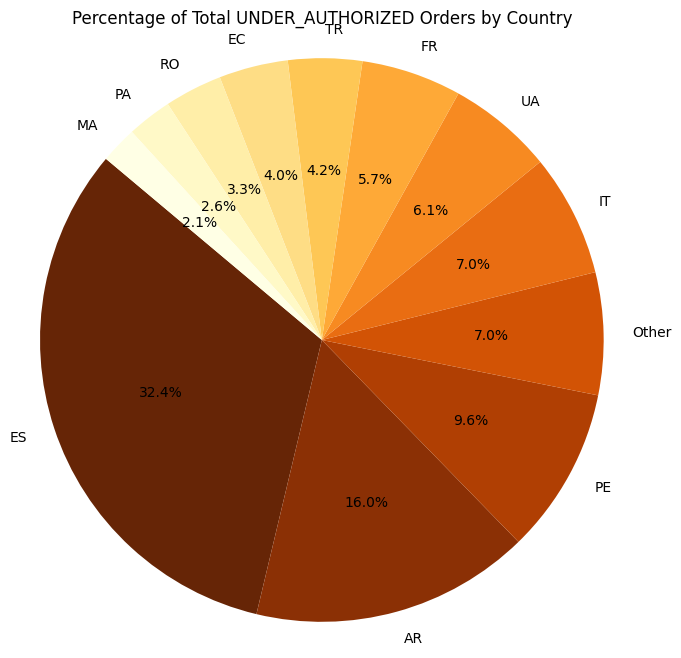

In [24]:
country_tot = country_totals.groupby('country_code')['products_total'].sum()
#sorted
country_tot = country_tot.sort_values(ascending=False)

colors = cm.get_cmap('YlOrBr', len(country_tot))
colors_reversed = list(reversed(colors(range(len(country_tot)))))


plt.figure(figsize=(8, 8))
plt.pie(country_tot, labels=country_tot.index, autopct='%1.1f%%', startangle=140, colors=colors_reversed)
plt.title('Percentage of Total UNDER_AUTHORIZED Orders by Country')
plt.axis('equal')  
plt.show()

# Question 4 - For the remainder of orders that would be outside of incremental auth what  values would be necessary to capture the remaining amount?

In [11]:
df["products_total_20"] = df["products_total"]*1.2

In [12]:
df['price_difference'] = 0  


df.loc[df['purchase_total_price'] > df['products_total_20'], 'price_difference'] = df['purchase_total_price'] - df['products_total_20']

/var/folders/sz/x51nf6p57096mncqbrxctq940000gn/T/ipykernel_83713/4260061201.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.192 3.048 7.71  ... 2.298 2.762 3.212]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df['purchase_total_price'] > df['products_total_20'], 'price_difference'] = df['purchase_total_price'] - df['products_total_20']


# Question 5 - Which stores are the most problematic in terms of orders and monetary value?  

# Question 6 For under-auth orders is there a correlation between the difference in the prices and  the cancellation of the order? In other words: Is an order more likely to be cancelled as the price difference increases?  


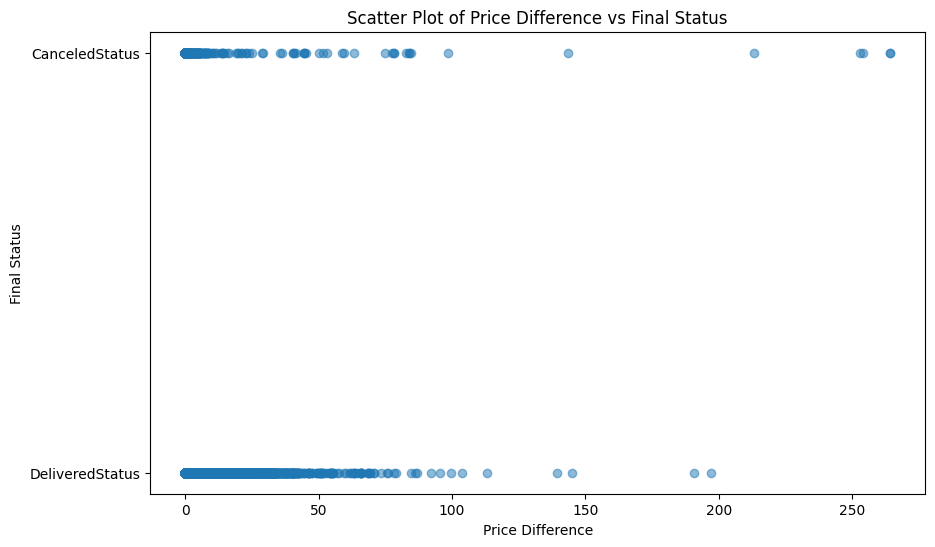

In [14]:
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the provided data

# Filter out under-authorized orders
under_auth_orders = df[df['auth_status'] == 'under-authorized']

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(under_auth_orders['price_difference'], under_auth_orders['final_status'], alpha=0.5)
plt.xlabel('Price Difference')
plt.ylabel('Final Status')
plt.title('Scatter Plot of Price Difference vs Final Status')
plt.show()

In [15]:
import numpy as np

# Assuming df is your DataFrame containing the provided data

# Filter out under-authorized orders
under_auth_orders = df[df['auth_status'] == 'under-authorized']

under_auth_orders['final_status_binary'] = (under_auth_orders['final_status'] == 'CanceledStatus').astype(int)

correlation = np.corrcoef(under_auth_orders['price_difference'], under_auth_orders['final_status_binary'])[0, 1]

print(f"The point-biserial correlation coefficient between price_difference and final_status is: {correlation:.2f}")

The point-biserial correlation coefficient between price_difference and final_status is: 0.12


/var/folders/sz/x51nf6p57096mncqbrxctq940000gn/T/ipykernel_83713/3785033801.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  under_auth_orders['final_status_binary'] = (under_auth_orders['final_status'] == 'CanceledStatus').astype(int)
